<a href="https://colab.research.google.com/github/CarlosTadeuVassoler/TCC/blob/main/exemplo_metano_PengR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelo de IA para modelar Temperatura em Função da Entalpia

## Importando bibliotecas

In [1]:
import torch #lidar com tensors (representação dos dados utilizada pela rede neural)
from torch import nn #modelos pre-desenvolvidos

from pathlib import Path #representar o caminho para um arquivo
import requests #fazer solicitações de HTTP (links)
import csv #salvar/carregar os dados de um csv

import matplotlib.pyplot as plt #plotar gráficos

## Obtendo dados

Utilizando o Aspen Plus V10 e o pacote termodinâmico Peng-Robinson, foi obtido um conjunto de dados para o metano (CH4) de entalpia molar em função da temperatura. Os dados foram gerados para uma pressão de 70 bar, um intervalo de temperaturas de 100 K a 300 K e um passo de 0,05 K, ou seja, temos 4000 pontos.

Uma vez gerados, armazenou-se os dados em um .csv, disponível em:
- https://github.com/CarlosTadeuVassoler/TCC/blob/main/dados_metano.csv

Para utilizar estes dados neste notebook, foi definida a função `baixar_csv`, mostrada abaixo:

In [3]:
def baixar_csv(data_path, nome):
  if not data_path.is_dir():
    data_path.mkdir(parents=True, exist_ok=True)

  if nome.split(".")[-1] != "csv":
    nome += ".csv"

  with open(data_path / nome, "wb") as f:
    request = requests.get("https://github.com/CarlosTadeuVassoler/TCC/raw/main/" + nome)
    f.write(request.content)

  temperaturas, entalpias = [], []

  with open(data_path / nome, "r") as f:
    leitor = csv.reader(f, delimiter=";")

    next(leitor)

    for linha in leitor:
      T, h = linha
      temperaturas.append(float(T.replace(",", ".")))
      entalpias.append(float(h.replace(",", ".")))

  return temperaturas, entalpias

In [4]:
data_path = Path("data/")
temperaturas, entalpias = baixar_csv(data_path, "dados_metano_PengR")

Como visto, os dados baixados foram armazenados nas matrizes `temperaturas` e `entalpias`. Um Exemplo destes dados pode ser visto a seguir:

In [5]:
print(f"Três primeiras temperaturas: {temperaturas[:3]}")
print(f"Três últimas temperaturas: {temperaturas[-3:]}")

Três primeiras temperaturas: [100.0, 100.05, 100.1]
Três últimas temperaturas: [299.9, 299.95, 300.0]


In [6]:
print(f"Três primeiras entaplias: {entalpias[:3]}")
print(f"Três últimas entalpias: {entalpias[-3:]}")

Três primeiras entaplias: [-89587.13674, -89584.49905, -89581.8195]
Três últimas entalpias: [-75710.86736, -75708.7, -75706.5]


Como estamos querendo modelar o comportamento não linear entre entalpia e temperatura, provavelmente vamos utilizar a função ReLU. Esta, para cada dado de entrada, retorna o valor máximo entre o próprio dado e 0:

- ReLU (X) = max(0, X)

Nota-se que isto pode ser um problema para os nossos dados, visto que temos um conjunto de entalpias negativas, o que pode prejudicar o treinamento do modelo. Desta forma, de cada um dos dados de entalpia, foi subtraído o menor valor conhecido, tornando todos os resultados maiores que 0.

Alguns dos valores novos das entalpias podem ser vistos abaixo:

In [7]:
entalpias_transformadas = [entalpia - min(entalpias) for entalpia in entalpias]
print(f"Três primeiras entaplias: {entalpias_transformadas[:3]}")
print(f"Três últimas entalpias: {entalpias_transformadas[-3:]}")

Três primeiras entaplias: [0.0, 2.6376900000032037, 5.317240000003949]
Três últimas entalpias: [13876.269379999998, 13878.436740000005, 13880.636740000002]


Os modelos de rede neural utilizam os tensors como formato de dado para suas tarefas. Da forma como vamos trabalhar, foi conveniente transformar os dados em tensors no seguinte formato:

- tensor: [[dado1], [dado2], ...]

A maneira como isto foi feito pode ser vista abaixo:

In [8]:
y_treino = torch.Tensor(temperaturas).unsqueeze(dim=1)
X_treino = torch.Tensor(entalpias_transformadas).unsqueeze(dim=1)

y_treino.shape, X_treino.shape

(torch.Size([4001, 1]), torch.Size([4001, 1]))

Por fim, para visualização dos dados tanto nesta etapa quanto nas posteriores, foi definida a função `plotar_grafico`, como mostrado abaixo:

In [9]:
def plotar_grafico(dados=[X_treino, y_treino],
                   previsoes=None,
                   labels=["H (kJ/kmol)", "T (K)"],
                   tipo="TxH"):
  
  if tipo != "TxH":
    labels = list(reversed(labels))
    dados = list(reversed(dados))

  plt.figure(figsize=(5, 5))
  plt.scatter(dados[0], dados[1], c="blue", s=10, label="Dados de Treino")
  plt.xlabel(labels[0])
  plt.ylabel(labels[1])

  if previsoes is not None:
    plt.scatter(previsoes[0], previsoes[1], c="green", s=10, label="Previsões")

  plt.legend(prop={"size": 8})

Segue um exemplo de cada um dos gráficos que vamos analisar:

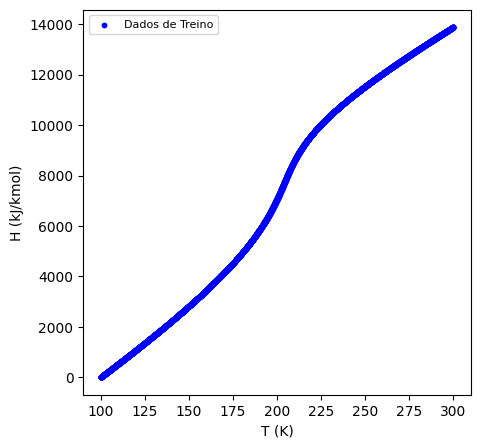

In [10]:
plotar_grafico(tipo="HxT")

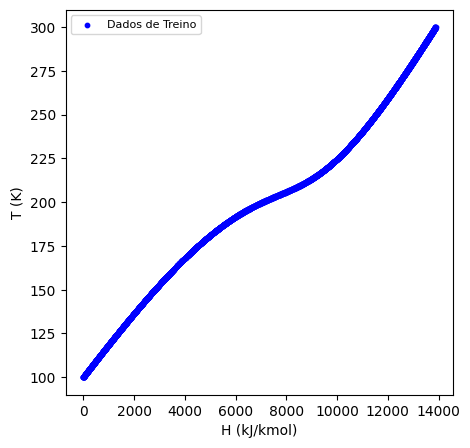

In [11]:
plotar_grafico()

## Criando o modelo

Apenas para testes preliminares, foi criado um modelo simples. Neste, temos uma camada geral com as seguintes subcamadas:

- `nn.Linear`: equação de reta y = ax + b;
- `nn.ReLU`: função de ativação para adicionar não linearidade ao modelo.

A sequência utilizada foi: Linear -> ReLU -> Linear -> ReLU -> Linear. O número de neurônios por camada foi definido como 12, por simplicidade, e tanto a entrada quanto a saída do modelo é um valor único (temperatura e entalpia).

In [12]:
class Modelo(nn.Module):
  def __init__(self):
    super().__init__()

    neuronios = 12

    self.camada1 = nn.Sequential(
        nn.Linear(in_features=1, out_features=neuronios),
        nn.ReLU(),
        nn.Linear(in_features=neuronios, out_features=neuronios),
        nn.ReLU(),
        nn.Linear(in_features=neuronios, out_features=1)
    )

  def forward(self, x):
    return self.camada1(x)

Foram definidas as funções `treinar`, `salvar_modelo` e `carregar_modelo`, que executam o que seus nomes sugerem. Uma vez treinado, é conveniente salvar o modelo para poupar tempo quando for necessário reutiliza-lo, o que pode ser feito com a função de carregarmento.

In [13]:
def treinar(modelo,
            y_treino,
            X_treino,
            epochs,
            loss_fun,
            otimizador):

  modelo.train()

  for epoch in range(epochs):
    y_logits = modelo(X_treino)
    loss = loss_fun(y_logits, y_treino)
    otimizador.zero_grad()
    loss.backward()
    otimizador.step()

    if (epoch + 1) % (epochs / 10) == 0:
      print(f"EPOCH: {epoch+1} | Loss: {loss:.4f}")

  modelo.eval()

In [14]:
def salvar_modelo(nome, modelo):
  MODEL_PATH = Path("models")
  MODEL_PATH.mkdir(parents=True, exist_ok=True)

  MODEL_NAME = nome
  MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
  torch.save(obj=modelo.state_dict(), f=MODEL_SAVE_PATH)

In [24]:
def carregar_modelo(data_path, modelo, nome):
  MODEL_PATH = Path("models")

  if not MODEL_PATH.is_dir():
    MODEL_PATH.mkdir(parents=True, exist_ok=True)

  with open(MODEL_PATH / nome, "wb") as f:
    request = requests.get("https://github.com/CarlosTadeuVassoler/TCC/raw/main/" + nome)
    f.write(request.content)

  modelo.load_state_dict(torch.load(f=MODEL_PATH / nome))

Julgou-se necessário gerar dois modelos com essa estrutura. Um para prever a entalpia para um dado valor de temperatura e outro o contrário. Além disso, utilizou-se como função de perda o erro absoluto médio (mean square error), para avaliar o quão erradas foram as previsões durante o treinamento.

In [28]:
qual_a_temp = Modelo()
qual_a_enth = Modelo()
loss_fun = nn.MSELoss()

A seguir, foi definida a função `obter_treinados`, que possui duas opções:

- OPCAO 1: treinar os modelos (executa a função `treinar`) e salvar os arquivos (executa a função `salvar_modelo`);
- OPCAO 2: carregar os modelos já salvos anteriormente (executa a função `carregar_modelo`).

In [17]:
def obter_treinados(OPCAO=1,
                    learning_rate=0.001,
                    EPOCHS=100000):
  #OPCAO = 1: treinar modelos
  #OPCAO = 2: baixar modelos

  if OPCAO == 1:
    print("Treinando T = f(H)")
    otimizador_temp = torch.optim.Adam(params=qual_a_temp.parameters(), lr=learning_rate)
    treinar(qual_a_temp, y_treino, X_treino, EPOCHS, loss_fun, otimizador_temp)
    salvar_modelo("TempVersusEnth.pth", qual_a_temp)

    print()
    print("Treinando H = f(T)")
    otimizador_enth = torch.optim.Adam(params=qual_a_enth.parameters(), lr=learning_rate)
    treinar(qual_a_enth, X_treino, y_treino, EPOCHS, loss_fun, otimizador_enth)
    salvar_modelo("EnthVersusTemp.pth", qual_a_enth)
  else:
    carregar_modelo(data_path, qual_a_temp, "TempVersusEnth.pth")
    carregar_modelo(data_path, qual_a_enth, "EnthVersusTemp.pth")

Uma vez treinados, é de grande utilidade visualizar como foram as previsões, além de conhecer os valores de perda. Para isto, foi definida a função `plotar_previsoes`.

In [18]:
def plotar_previsoes(modelo, dados, tipo):
  with torch.inference_mode():
    y_logits = modelo(dados)

  plotar_grafico(previsoes=[dados, y_logits],
                 tipo=tipo)

## Treinando o modelo

O primeiro treinamento foi realizado em poucas épocas com uma taxa de aprendizado alta (lembrando que o otimizador Adam trabalha melhor em baixas taxas de aprendizado, sendo seu padrão igual a 0.001). Isto apenas para testar se o modelo conseguiria prever alguma coisa. Seguem os resultados de treinamento (perdas e previsões)

In [29]:
obter_treinados(OPCAO=1, learning_rate=0.01, EPOCHS=1000)

Treinando T = f(H)
EPOCH: 100 | Loss: 3469.6077
EPOCH: 200 | Loss: 3808.5054
EPOCH: 300 | Loss: 3352.2412
EPOCH: 400 | Loss: 3276.4932
EPOCH: 500 | Loss: 3154.5225
EPOCH: 600 | Loss: 3119.1794
EPOCH: 700 | Loss: 3108.2576
EPOCH: 800 | Loss: 3011.9912
EPOCH: 900 | Loss: 2921.9099
EPOCH: 1000 | Loss: 2817.9968

Treinando H = f(T)
EPOCH: 100 | Loss: 17176816.0000
EPOCH: 200 | Loss: 5790760.5000
EPOCH: 300 | Loss: 5774234.5000
EPOCH: 400 | Loss: 5755891.0000
EPOCH: 500 | Loss: 5736186.5000
EPOCH: 600 | Loss: 5715373.5000
EPOCH: 700 | Loss: 5693568.5000
EPOCH: 800 | Loss: 5670820.5000
EPOCH: 900 | Loss: 5647100.5000
EPOCH: 1000 | Loss: 5622324.5000


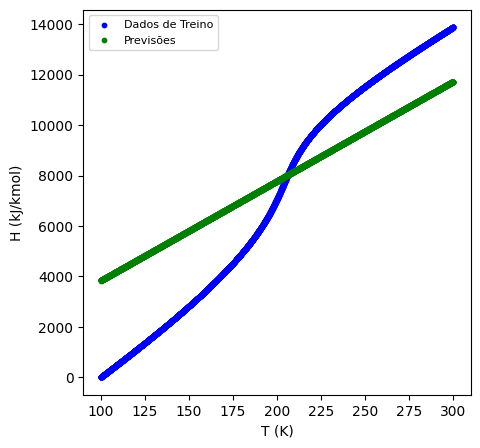

In [30]:
plotar_previsoes(qual_a_enth,
                 dados=y_treino,
                 tipo="HxT")

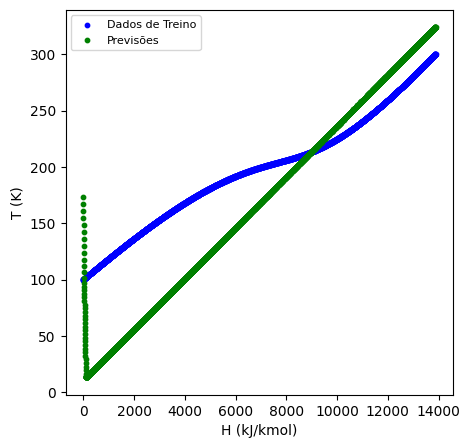

In [31]:
plotar_previsoes(qual_a_temp,
                 dados=X_treino,
                 tipo="TxH")

Em um primeiro momento, vemos que o modelo conseguiu adequar as previsões para um intervalo coerente, porém o comportamento não foi bem representado. Ajustou-se a taxa de aprendizado e o número de épocas, repetindo-se o processo de treinamento e avaliação (lembrando que os parâmetros dos modelos obtidos até agora não são descartados, o aprendizado parte dos valores atuais).

In [32]:
obter_treinados(OPCAO=1, learning_rate=0.002, EPOCHS=10000)

Treinando T = f(H)
EPOCH: 1000 | Loss: 5.0009
EPOCH: 2000 | Loss: 9.1603
EPOCH: 3000 | Loss: 10.8920
EPOCH: 4000 | Loss: 9.2224
EPOCH: 5000 | Loss: 17.0301
EPOCH: 6000 | Loss: 6.4846
EPOCH: 7000 | Loss: 2.1958
EPOCH: 8000 | Loss: 4.5536
EPOCH: 9000 | Loss: 8.5475
EPOCH: 10000 | Loss: 5.0039

Treinando H = f(T)
EPOCH: 1000 | Loss: 4303007.0000
EPOCH: 2000 | Loss: 780744.5625
EPOCH: 3000 | Loss: 151650.7812
EPOCH: 4000 | Loss: 85627.0312
EPOCH: 5000 | Loss: 62764.9492
EPOCH: 6000 | Loss: 46774.5781
EPOCH: 7000 | Loss: 32451.0039
EPOCH: 8000 | Loss: 20769.9551
EPOCH: 9000 | Loss: 12592.0605
EPOCH: 10000 | Loss: 7517.6709


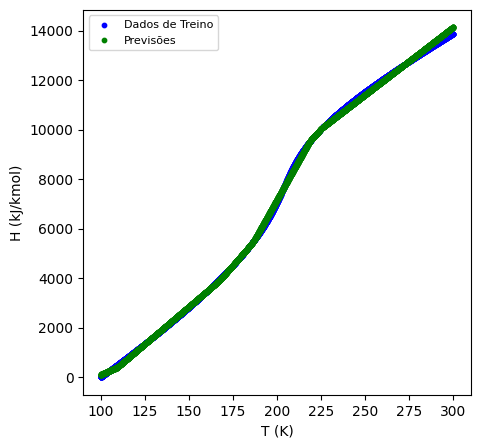

In [33]:
plotar_previsoes(qual_a_enth,
                 dados=y_treino,
                 tipo="HxT")

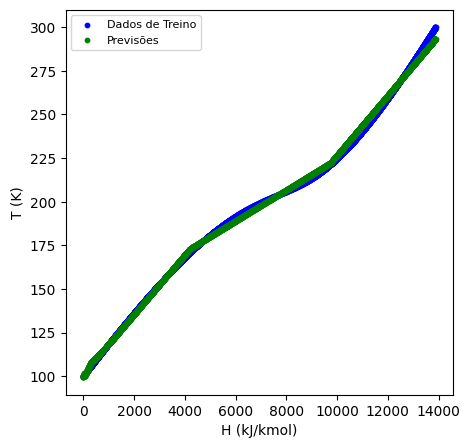

In [34]:
plotar_previsoes(qual_a_temp,
                 dados=X_treino,
                 tipo="TxH")

Aumentando o número de épocas e diminuindo a taxa de aprendizado (ajuste fino):

In [35]:
obter_treinados(OPCAO=1, learning_rate=0.0002, EPOCHS=100000)

Treinando T = f(H)
EPOCH: 10000 | Loss: 0.7408
EPOCH: 20000 | Loss: 0.7258
EPOCH: 30000 | Loss: 0.6826
EPOCH: 40000 | Loss: 0.6820
EPOCH: 50000 | Loss: 0.7269
EPOCH: 60000 | Loss: 0.6840
EPOCH: 70000 | Loss: 0.6822
EPOCH: 80000 | Loss: 0.7211
EPOCH: 90000 | Loss: 0.6884
EPOCH: 100000 | Loss: 0.7172

Treinando H = f(T)
EPOCH: 10000 | Loss: 1788.8527
EPOCH: 20000 | Loss: 863.2373
EPOCH: 30000 | Loss: 594.9059
EPOCH: 40000 | Loss: 485.8393
EPOCH: 50000 | Loss: 432.2174
EPOCH: 60000 | Loss: 396.2693
EPOCH: 70000 | Loss: 368.2698
EPOCH: 80000 | Loss: 347.1177
EPOCH: 90000 | Loss: 332.4929
EPOCH: 100000 | Loss: 322.8102


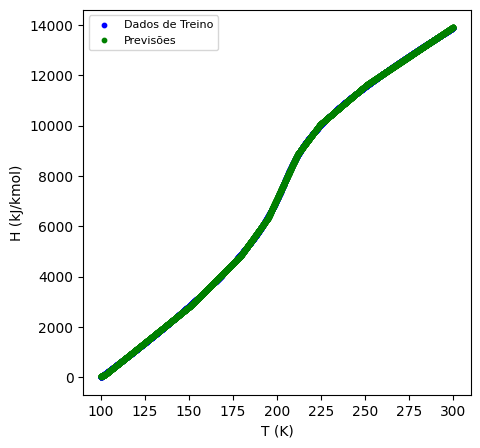

In [36]:
plotar_previsoes(qual_a_enth,
                 dados=y_treino,
                 tipo="HxT")

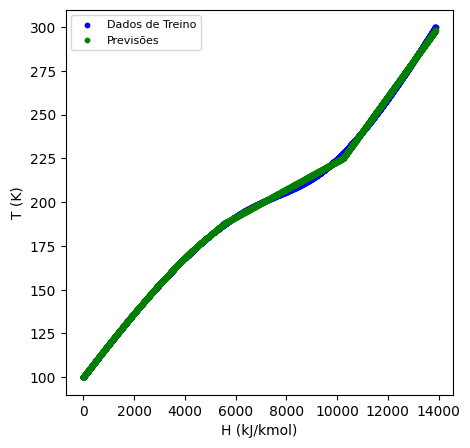

In [37]:
plotar_previsoes(qual_a_temp,
                 dados=X_treino,
                 tipo="TxH")

Vemos que as curvas estão praticamente sobrepostas, logo, vamos parar por aqui, visto que não precisamos de um modelo perfeito neste momento, isto é apenas um teste. Diversas alterações podem ser feitas futuramente, como:

- Determinar um learning rate melhor, para deixar cada época de treino o mais eficiente possível;
- Aumentar o número de neurônios ou camadas do modelo (deixar mais complexa a arquitetura);
- Separar os dados em bateladas/lotes, para que a cada época, tenham-se diversas atualizações de parâmetros, o que favorece o aprendizado (BATCH_SIZE = 32, teríamos 4000 / 32 = 125 conjuntos de dados, ou seja, 125 atualizações de parâmetros por época de treinamento, o que é bom desde que os dados recebam uma aleatoriedade para evitar que o modelo aprenda um intervalo de cada vez);
- Gerar mais pontos;
- Entre outros.

## Exemplo de um trocador de calor

Suponha um trocador com uma carga térmica de 6000 kW. Neste, passa uma corrente de metano que foi dividida anteriormente com uma fração de 0,4. A vazão molar da corrente cheia é 3 kmol/s e a temperatura no misturador é 142 K.

Vamos utilizar os modelos treinados para definir as condições de saída da corrente. A seguir foram computados estes dados:

In [38]:
Tmix = 142
Fc = 0.4
Q = 6000
wsplit = 3

Tmix_tensor = torch.Tensor([Tmix]).unsqueeze(dim=1)

O primeiro passo é definir a entalpia molar da corrente na temperatura de entrada utilizando o modelo `qual_a_enth`, lembrando que precisamos corrigir o resultado obtido pela rede neural (problemas com o ReLU).

In [39]:
with torch.inference_mode():
  entalpia_mix = qual_a_enth(Tmix_tensor)

entalpia_mix_certa = entalpia_mix + min(entalpias)
entalpia_mix_certa

tensor([[-87257.0625]])

Em seguida, calcula-se a entalpia da corrente após receber os 6000 kW, como mostrado a seguir:

In [40]:
entalpia_final = entalpia_mix_certa * wsplit * Fc + Q
entalpia_final

tensor([[-98708.4766]])

Voltando para entalpia molar o obtendo uma previsão de temperatura utilizando o modelo `qual_a_temp`:

In [41]:
enth_final_molar = entalpia_final / wsplit / Fc
enth_final_transformada = enth_final_molar - min(entalpias)
with torch.inference_mode():
  temp_final = qual_a_temp(enth_final_transformada)

temp_final.item()

202.00987243652344

A temperatura obtida foi de 202 K.